[View in Colaboratory](https://colab.research.google.com/github/nanometers/QuantWork/blob/master/testingQuantData.ipynb)

In [42]:
!pip install pandas
!pip install pandas-datareader
!pip install numpy
!pip install sklearn
!pip install matplotlib

In [0]:
from pandas_datareader import data as web
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV as rcv
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
from IPython import get_ipython

In [0]:
avg_err = {}
avg_train_err = {}
df = web.DataReader('SPY', 'morningstar', start = '2007-01-01', end = '2017-01-01')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df['open'] = df['Open'].shift(1)
df['high'] = df['High'].shift(1)
df['low'] = df['Low'].shift(1)
df['close'] = df['Close'].shift(1)
df['volume'] = df['Volume'].shift(1)

In [45]:
df.head()

Open    High     Low   Close    Volume    open    high  \
Symbol Date                                                                   
SPY    2007-01-01  142.06  142.54  141.43  141.62         0     NaN     NaN   
       2007-01-02  142.06  142.54  141.43  141.62         0  142.06  142.54   
       2007-01-03  142.25  142.86  140.57  141.37  94807600  142.06  142.54   
       2007-01-04  141.23  142.05  140.61  141.67  69620600  142.25  142.86   
       2007-01-05  141.33  141.40  140.38  140.54  76645300  141.23  142.05   

                      low   close      volume  
Symbol Date                                    
SPY    2007-01-01     NaN     NaN         NaN  
       2007-01-02  141.43  141.62         0.0  
       2007-01-03  141.43  141.62         0.0  
       2007-01-04  140.57  141.37  94807600.0  
       2007-01-05  140.61  141.67  69620600.0


Average Range of the Day: 1.5074435114503804


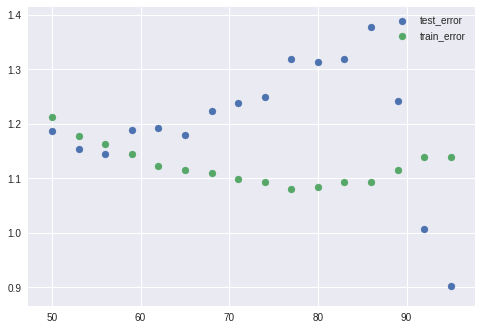

In [46]:

X = df[['open', 'high', 'low', 'close']]
y = df['Close']

imp = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)

steps = [('imputation', imp), ('scaler', StandardScaler()), ('lasso', Lasso())]

pipeline = Pipeline(steps)

parameters = {'lasso__alpha': np.arange(.0001, 10, .0001), 
             'lasso__max_iter': np.random.uniform(100, 1000000, 4)}

reg = rcv(pipeline, parameters, cv = 5)

for t in np.arange(50, 97, 3):
  get_ipython().magic('reset_selective -f reg1')
  split = int(t*len(X)/100)
  reg.fit(X[:split], y[:split])
  best_alpha = reg.best_params_['lasso__alpha']
  best_iter = reg.best_params_['lasso__max_iter']
  reg1 = Lasso(alpha = best_alpha, max_iter = best_iter)
  X = imp.fit_transform(X, y)
  reg1.fit(X[:split], y[:split])
  
  df['P_C_%i'%t] = 0
  df.iloc[:,df.columns.get_loc('P_C_%i'%t)] = reg1.predict(X[:])
  df['Error_%i'%t] = np.abs(df['P_C_%i'%t] - df['Close'])
  
  e = np.mean(df['Error_%i'%t][split:])
  train_e = np.mean(df['Error_%i'%t][:split])
  avg_err[t] = e
  avg_train_err[t] = train_e

Range = df['high'][split:] - df['low'][split:]

plt.scatter(list(avg_err.keys()), list(avg_err.values()), label = 'test_error')
plt.scatter(list(avg_train_err.keys()), list(avg_train_err.values()), label = 'train_error')
plt.legend(loc='best')
print('\nAverage Range of the Day:', np.average(Range))
